In [1]:
import os
import glob
import keras
from keras_video import VideoFrameGenerator

# use sub directories names as classes
classes = [i.split(os.path.sep)[1] for i in glob.glob('F:/DLProj/v5_2/train/*')]
classes.sort()
# some global params
SIZE = (300, 300)
CHANNELS = 3
NBFRAME = 15
BS = 5
# pattern to get videos and classes
glob_pattern='F:/DLProj/v5_2/train/{classname}/*.mp4'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.25,  # 33% of the videos will be used as validation set. 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=False)

Using TensorFlow backend.


class door, validation count: 28, train count: 87
class not_door, validation count: 30, train count: 91
Total data: 2 classes for 178 files for train


In [6]:
# Code for Clearing the GPU memory
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
valid = train.get_validation_generator()

Total data: 2 classes for 58 files for validation


In [3]:
import keras_video.utils
keras_video.utils.show_sample(train)

<Figure size 2200x2500 with 75 Axes>

In [ ]:
import gc
del model
gc.collect()

# Time-Distributed CNN + LSTM Implementation

In [4]:
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D,MaxPooling2D)
from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop
from collections import deque
from keras.regularizers import l2
from keras.layers import BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.layers.core import Dense, Dropout, Activation, Flatten


def add_default_block(model, kernel_filters, init, reg_lambda):
    # conv
    model.add(TimeDistributed(Conv2D(kernel_filters, (3, 3), padding='same',
                            kernel_initializer=init, kernel_regularizer=l2(l=reg_lambda))))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('relu')))
    # conv
    model.add(TimeDistributed(Conv2D(kernel_filters, (3, 3), #padding='same',
                            kernel_initializer=init, kernel_regularizer=l2(l=reg_lambda))))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('relu')))
    # max pool
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    return model

"""Build a CNN into RNN.
Starting version from:
https://github.com/udacity/self-driving-car/blob/master/steering-models/community-models/chauffeur/models.py
Heavily influenced by VGG-16:
https://arxiv.org/abs/1409.1556

Also known as an LRCN:
https://arxiv.org/pdf/1411.4389.pdf
"""

initialiser = 'glorot_uniform'
reg_lambda  = 0.001

model = Sequential()

# first (non-default) block
model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(3, 3), #padding='same',
                                    kernel_initializer=initialiser, kernel_regularizer=l2(l=reg_lambda),
                                     activation = 'relu'
                                    ),
                                    input_shape=(15, 300, 300, 3)
                                     ))
#model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(32, (3,3), 
                                 kernel_initializer=initialiser, 
                                 kernel_regularizer=l2(l=reg_lambda)))
                                 )
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# 2nd-5th (default) blocks
model = add_default_block(model, 64,  init=initialiser, reg_lambda=reg_lambda)
model = add_default_block(model, 128, init=initialiser, reg_lambda=reg_lambda)
model = add_default_block(model, 256, init=initialiser, reg_lambda=reg_lambda)
#model = add_default_block(model, 512, init=initialiser, reg_lambda=reg_lambda)

# LSTM output head
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, return_sequences=False, dropout=0.5))
model.add(Dense(128, activation= 'relu'))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(2, activation='softmax'))

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
model.summary()

#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 98, 98, 32)    4736      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 96, 96, 32)    9248      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 96, 96, 32)    128       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 96, 96, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 48, 48, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 48, 48, 64)    18496     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 48, 48, 64)   

In [5]:
#optimizer = Adam(lr=1e-5, decay=1e-6)
optimizer= RMSprop(lr=1e-4)
model.compile(optimizer=optimizer , 
              loss='categorical_crossentropy',
              #loss='binary_crossentropy',
              metrics=['accuracy'])

In [6]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
import os.path
import time

early_stopper = EarlyStopping(patience=5)
#tb = TensorBoard(log_dir=os.path.join('F:\DLProj\ver4', 'logs'))
timestamp = time.time()
csv_logger =  CSVLogger(os.path.join('F:\\DLProj\\v4_1\\train\\logs', 'logs' + '-' + 'training-' + \
                        str(timestamp) + '.log'))

# Create a TensorBoard logger
tb = TensorBoard(
    log_dir='logs',
    write_graph=True,
    histogram_freq=5)

In [16]:
keras.backend.clear_session()

In [7]:
history = model.fit_generator(
                    train, 
                    validation_data= valid, 
                    #batch_size= 5,
                    verbose=1,
                    callbacks=[ csv_logger,
                    keras.callbacks.ModelCheckpoint('F:/DLProj/v4_1/1.{epoch:02d}-{val_loss:.2f}.hdf5',verbose=1),
],
                    epochs = 50)

Epoch 1/50
35/35 [==============================] - 213s 6s/step - loss: 1.4946 - accuracy: 0.4857 - val_loss: 1.4645 - val_accuracy: 0.5455

Epoch 00001: saving model to F:/DLProj/v4_1/1.01-1.46.hdf5
Epoch 2/50
35/35 [==============================] - 170s 5s/step - loss: 1.4666 - accuracy: 0.5543 - val_loss: 1.5340 - val_accuracy: 0.5091

Epoch 00002: saving model to F:/DLProj/v4_1/1.02-1.53.hdf5
Epoch 3/50
35/35 [==============================] - 210s 6s/step - loss: 1.4957 - accuracy: 0.5143 - val_loss: 1.5666 - val_accuracy: 0.5091

Epoch 00003: saving model to F:/DLProj/v4_1/1.03-1.57.hdf5
Epoch 4/50
35/35 [==============================] - 155s 4s/step - loss: 1.4653 - accuracy: 0.6057 - val_loss: 1.6297 - val_accuracy: 0.5091

Epoch 00004: saving model to F:/DLProj/v4_1/1.04-1.63.hdf5
Epoch 5/50
35/35 [==============================] - 222s 6s/step - loss: 1.4675 - accuracy: 0.5257 - val_loss: 1.7562 - val_accuracy: 0.5273

Epoch 00005: saving model to F:/DLProj/v4_1/1.05-1.76.

In [10]:
from keras.models import model_from_json
# serialize model to json
json_model = model.to_json()
#save the model architecture to JSON file
with open('F:/DLProj/v4_1/train/Model/v1.json', 'w') as json_file:
    json_file.write(json_model)

In [8]:
model.save_weights('ver_4_1_gen_model_weights.h5')

# Save the model architecture
with open('ver_4_1_gen_model_architecture.json', 'w') as f:
    f.write(model.to_json())

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


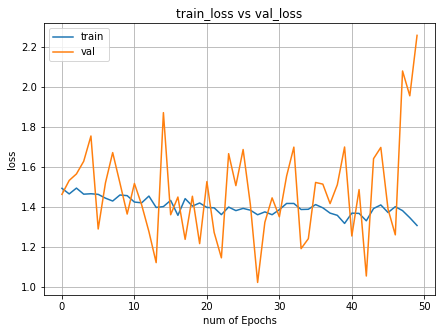

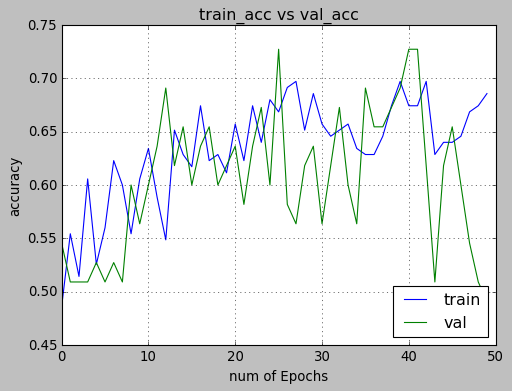

In [9]:
import matplotlib.pyplot as plt
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
xc=range(50)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
print (plt.style.available) # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [36]:
del plt